# Classical Split Conformal Prediction

This notebook shows how to implement Split Conformal Prediction from scratch, a naive and simple approach that provides us with fixed-width prediction bands with theoretical coverage guarantees. It does so by estimating quantiles of the mean absolute error distribution on a calibration set.

In short, we implement the (default) [absolute residual scores from MAPIE](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) from scratch and verify that both implementations actually produce the same results.

See Section 2.2 of the following paper for a precise description of the method:

*Lei, J., G’Sell, M., Rinaldo, A., Tibshirani, R. J., & Wasserman, L. (2018). Distribution-Free Predictive Inference for Regression. Journal of the American Statistical Association, 113(523), 1094–1111. Available from https://doi.org/10.1080/01621459.2017.1307116*

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from util import regression_plot_with_uncertainty

Since we have to plot a lot of prediction bands, let us define a utility function for obtaining them from the predictive mean and the absolute error quantiles.

In [3]:
def construct_prediction_bands(mean_prediction, quantiles):
    """
    A function that returns the lower and upper prediction bands for every quantile in quantiles.
    """
    
    prediction_bands = np.zeros((len(mean_prediction), 2, len(quantiles)))

    for i, q in enumerate(quantiles):
        prediction_bands[:, :, i] = np.stack([
            mean_prediction - q,
            mean_prediction + q
        ], axis=1)

    return prediction_bands

## Generate Toy Dataset with Homoscedastic Noise

We sample data from a linear model $f(x)$ with homoscedastic noise with standard deviation $\sigma$, where $x$ consists of equally spaced inputs in the range $[0, 1]$.

In [4]:
def f(x):
    """Linear function used to generate one-dimensional data."""
    return np.array(5 * x + 2)

In [5]:
def generate_homoscedastic_data(n_samples, sigma=0.1, random_state=42):
    """
    Generate one-dimensional data from a given function with a given noise standard deviation.
    """
    np.random.seed(random_state)
    X = np.linspace(0, 1, n_samples)[:, np.newaxis]
    y = f(X) + np.random.normal(0, sigma, (n_samples, 1))
    y_gt = f(X)
    return X, y.ravel(), y_gt.ravel()

Let's generate the data for $\sigma=0.5$.

In [6]:
sigma = 0.5
X, y, y_gt = generate_homoscedastic_data(n_samples=500, sigma=sigma, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Let's plot the ground-truth function and ground-truth 95% prediction intervals of the sampling distribution. We also add a couple of test points to the plot to verify that around 95% of them lie indeed inside the error bars.

In [7]:
print(f'Expected number of points outside the 95% error bars: {len(X_cal) * 0.05}')

Expected number of points outside the 95% error bars: 4.5


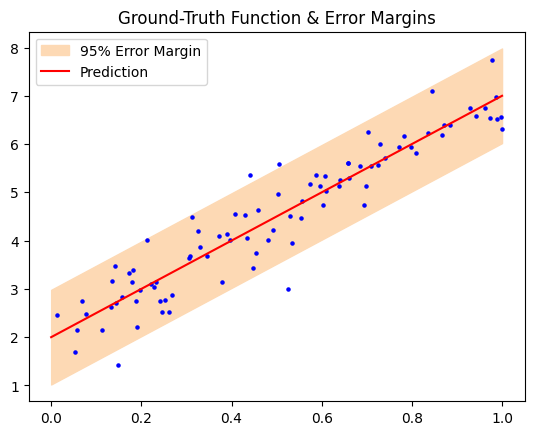

In [8]:
fig, ax = plt.subplots(1, 1)
# The 97.5th percentile of the standard normal distribution (for \sigma=1.0)
q975 = scipy.stats.norm.ppf(0.975)
# Since we sampled our data using y_gt + N(0, sigma),
# the alpha=0.05 prediction bands should be [y_gt - sigma * q975, y_gt + sigma * q975]
# q025 = -q975 here because the normal distribution is symmetric
prediction_bands = construct_prediction_bands(y_gt, [sigma * q975])
regression_plot_with_uncertainty(ax, X, y_gt, prediction_bands, (X_cal, y_cal), labels=['95% Error Margin'])
ax.set_title('Ground-Truth Function & Error Margins')
plt.show()

The plot confirms that the ground-truth predictive bands indeed capture around 95% of the calibration points that we plotted.

## Absolute Residual Scores

We will now start implementing *absolute residual scores* from scratch. See section 1 of the [MAPIE documentation](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) for a reference.

In [9]:
# For the mean predictor, we choose a linear regression model as this matches the ground-truth function
mean_predictor = LinearRegression()
mean_predictor.fit(X_train, y_train)
y_train_predict = mean_predictor.predict(X_train)

In order to obtain our bands, we need to check the distribution of absolute prediction errors on the calibration set:

$$| y - \hat{\mu}(X) |,$$

where $\hat{\mu}(X)$ are our mean predictions and $y$ the target variable. These errors are also called *Absolute Residual Scores* in our case.

In [10]:
cal_mean_prediction = mean_predictor.predict(X_cal)

scores = np.abs(y_cal - cal_mean_prediction)

We now compute the $(1-\alpha)$-quantiles of the calibration scores to determine the correct prediction bands.

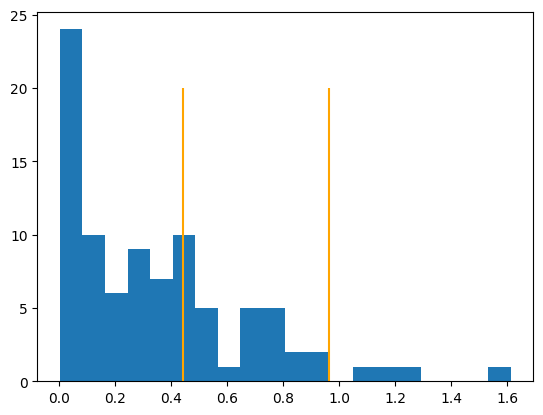

In [11]:
alphas = [0.05, 0.32]
# Setting method='higher' is a nuance here to ensure we actually get the same quantiles as MAPIE's implementation later on
quantiles = [np.nanquantile(scores, 1.0-alpha, method='higher') for alpha in alphas]
plt.hist(scores, bins=20)
plt.vlines(quantiles, ymin=0, ymax=20, color='orange')
plt.show()

Finally, we add/subtract these quantiles from our mean prediction $\hat{\mu}(X)$ giving the desired error bands.

Intuitively, this makes a lot of sense! If we capture 95% of the prediction errors on the calibration set with the $0.95$-quantile, then this should be a good candidate for predictive bands with the same coverage guarantee. The calibration set is used here instead of the training set, since we would be susceptible to underestimate the errors otherwise. This is because the model is fitted to reduce such errors and would therefore incur a bias.

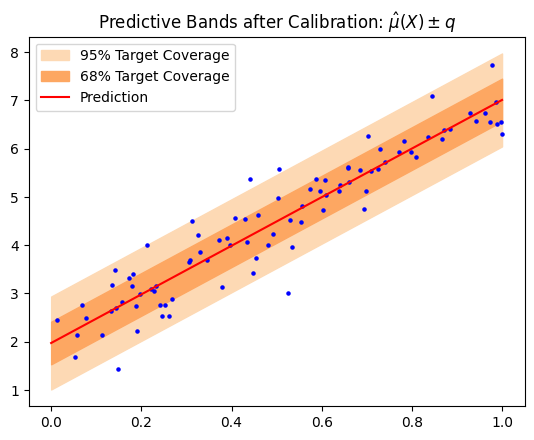

In [12]:
mean_prediction = mean_predictor.predict(X)
prediction_bands = construct_prediction_bands(mean_prediction, quantiles)

fig, ax = plt.subplots(1, 1)
regression_plot_with_uncertainty(
    ax,
    X,
    mean_prediction,
    prediction_bands,
    (X_cal, y_cal),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)
ax.set_title(r'Predictive Bands after Calibration: $\hat{\mu}(X) \pm q$')
plt.show()

The bands are slightly larger than the ground-truth ones because the calibration set had more than the expected number of points falling outside the 95% error range due to sampling uncertainty.

Per design, we should have roughly ($1-\alpha$) coverage on the calibration and test sets. Let's double check!

In [13]:
def compute_coverage(y, prediction_bands):
    num_points_outside = np.sum((y < prediction_bands[:,0]) | (y > prediction_bands[:,1]))
    coverage_score = 1.0-num_points_outside/len(y)
    return coverage_score

In [14]:
cal_prediction_bands = construct_prediction_bands(cal_mean_prediction, quantiles)
test_mean_prediction = mean_predictor.predict(X_test)
test_prediction_bands = construct_prediction_bands(test_mean_prediction, quantiles)

for i, alpha, q in zip(list(range(len(quantiles))), alphas, quantiles):
    print()
    print(f'Alpha: {alpha} (Target coverage: {(1.0-alpha)*100:.2f}%)')
    print('-'*50)
    coverage = compute_coverage(y_cal, cal_prediction_bands[:,:,i])
    print(f"Actual coverage on the calibration set: {coverage * 100:.2f}%")
    coverage = compute_coverage(y_test, test_prediction_bands[:,:,i])
    print(f"Actual coverage on the test set: {coverage * 100:.2f}%")


Alpha: 0.05 (Target coverage: 95.00%)
--------------------------------------------------
Actual coverage on the calibration set: 95.56%
Actual coverage on the test set: 96.00%

Alpha: 0.32 (Target coverage: 68.00%)
--------------------------------------------------
Actual coverage on the calibration set: 68.89%
Actual coverage on the test set: 74.00%


Most of the values look quite good! But why does the actual coverage on the test set deviate so much for $\alpha=0.32$? There are two reasons for this deviation:

1) The score quantiles were obtained using a finite calibration set of a given size. The larger this set, the better our estimation of the quantiles and the less variance we get for test coverage (see Section 2.3 of [this manuscript](https://www.stat.berkeley.edu/~ryantibs/statlearn-s23/lectures/conformal.pdf)).
2) The coverage guarantees that we get are probabilistic meaning that they hold on average. We can still draw unlucky test samples for which the observed coverage deviates, but this becomes less of an issue when the test set size increases.

## Comparison against MAPIE

Finally, we want to double check whether our implementation matches the one from MAPIE.

In [14]:
# MAPIE code to fit the same model

from mapie.regression import MapieRegressor
from mapie.conformity_scores import AbsoluteConformityScore

# By default conformity_score=None => AbsoluteConformityScore is used
# See here for a documentation: https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html
mapie_regressor = MapieRegressor(mean_predictor, conformity_score=None, cv='prefit', method='base')
mapie_regressor.fit(X_cal, y_cal)
y_pred, y_pis = mapie_regressor.predict(X, alpha=alphas)

Let's start by verifying whether our manually computed prediction bands are indeed equal up to $\epsilon$.

In [15]:
epsilon = 1e-12
proportion_equal_vals = np.mean( np.abs(y_pis-prediction_bands) < epsilon )
print(f'{proportion_equal_vals*100:.2f}% of values are equal.')

100.00% of values are equal.


That looks good! Our implementation seems to be correct!

For completeness, let's also confirm that we obtain the same plot as before. For a clearer comparison, we put them side by side. This time we plot the test points instead of the calibration points.

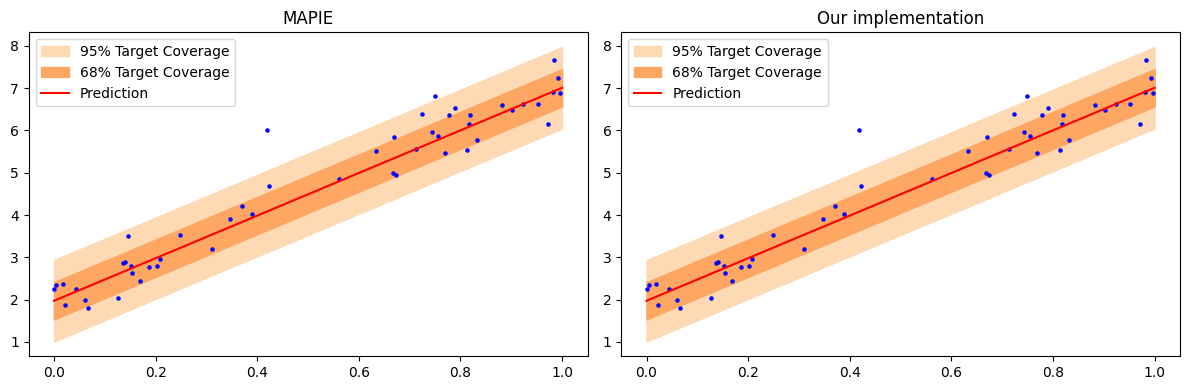

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
regression_plot_with_uncertainty(
    ax[0],
    X,
    y_pred,
    y_pis,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

regression_plot_with_uncertainty(
    ax[1],
    X,
    mean_prediction,
    prediction_bands,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

ax[0].set_title('MAPIE')
ax[1].set_title('Our implementation')
plt.tight_layout()
plt.show()

Constant prediction bands worked very well in this example because the noise was homoscedastic and we knew that the ground-truth model was indeed linear. In practice however, it can happen that the noise is either heteroscedastic or that our fitted model only matches the ground-truth in certain input regions. In both cases, it would be beneficial to capture predictive uncertainties that can vary between input regions. We will cover an approach to achieve this in the next notebook.